# STA 141C Homework 2

## Sungwon Lee
## 912978026

In [1]:
import pprint
import numpy as np
import pandas as pd
import scipy.linalg as sl
from sklearn.linear_model import LinearRegression
from scipy.linalg import cho_factor, cho_solve
import matplotlib.pylab as plt
import scipy.sparse as sparse
import time
import math

## Problem 1

#### 1.1 Read the data and include an intercept in your model

In [2]:
# Read the data by using pandas
longley = pd.read_csv("longley.dat", header=None, delim_whitespace=True)

In [3]:
# Rename the column 
longley.rename(columns={0:"number of people employed", 1:"GNP implicit price deflator", 2: "GNP", 3:"number of unemployed",
4: "number of people in the armed forces", 5: "noninst. pop", 6: "year"}, inplace=True)

longley.head()


,number of people employed,GNP implicit price deflator,GNP,number of unemployed,number of people in the armed forces,noninst. pop,year
0,60323,83.0,234289,2356,1590,107608,1947
1,61122,88.5,259426,2325,1456,108632,1948
2,60171,88.2,258054,3682,1616,109773,1949
3,61187,89.5,284599,3351,1650,110929,1950
4,63221,96.2,328975,2099,3099,112075,1951


In [4]:
# Use Linear Regression module
lm = LinearRegression()

# Y
Y = longley.iloc[:,0:1]

# X
X = longley.iloc[:,1:]

# fit data
model = lm.fit(X, Y)


print(model.coef_)
print(model.intercept_)



[[ 1.50618723e+01 -3.58191793e-02 -2.02022980e+00 -1.03322687e+00
  -5.11041057e-02  1.82915146e+03]]
[-3482258.63459582]


### 1.2

#### LU decomposition

In [5]:
# make array of A and b from the data
A = longley.iloc[:,1:]
b = longley.iloc[:,0:1]

A = np.array(A)

# add column of one for intercept
ncol = np.array(np.repeat(1, len(A)))
ncol = ncol.reshape(-1,1)
# ncol.shape

An = np.append(A, ncol, axis=1)

An = An[:, [6,0,1,2,3,4,5]]




print(np.array_str(An, precision=5, suppress_small=True))



[[     1.      83.  234289.    2356.    1590.  107608.    1947. ]
 [     1.      88.5 259426.    2325.    1456.  108632.    1948. ]
 [     1.      88.2 258054.    3682.    1616.  109773.    1949. ]
 [     1.      89.5 284599.    3351.    1650.  110929.    1950. ]
 [     1.      96.2 328975.    2099.    3099.  112075.    1951. ]
 [     1.      98.1 346999.    1932.    3594.  113270.    1952. ]
 [     1.      99.  365385.    1870.    3547.  115094.    1953. ]
 [     1.     100.  363112.    3578.    3350.  116219.    1954. ]
 [     1.     101.2 397469.    2904.    3048.  117388.    1955. ]
 [     1.     104.6 419180.    2822.    2857.  118734.    1956. ]
 [     1.     108.4 442769.    2936.    2798.  120445.    1957. ]
 [     1.     110.8 444546.    4681.    2637.  121950.    1958. ]
 [     1.     112.6 482704.    3813.    2552.  123366.    1959. ]
 [     1.     114.2 502601.    3931.    2514.  125368.    1960. ]
 [     1.     115.7 518173.    4806.    2572.  127852.    1961. ]
 [     1. 

In [6]:


# forward substitution
def forward_substitution(L, b):
    
    #Get number of rows
    n = L.shape[0]
    
    #Allocating space for the solution vector
    y = np.zeros_like(b, dtype=np.double);
    
    #Here we perform the forward-substitution.  
    #Initializing  with the first row.
    y[0] = b[0] / L[0, 0]
    
    #Looping over rows in reverse (from the bottom  up),
    #starting with the second to last row, because  the 
    #last row solve was completed in the last step.
    for i in range(1, n):
        y[i] = (b[i] - np.dot(L[i,:i], y[:i])) / L[i,i]
        
    return y


# backward substituion
def back_substitution(U, y):
    
    #Number of rows
    n = U.shape[0]
    
    #Allocating space for the solution vector
    x = np.zeros_like(y, dtype=np.double);

    #Here we perform the back-substitution.  
    #Initializing with the last row.
    x[-1] = y[-1] / U[-1, -1]
    
    #Looping over rows in reverse (from the bottom up), 
    #starting with the second to last row, because the 
    #last row solve was completed in the last step.
    for i in range(n-2, -1, -1):
        x[i] = (y[i] - np.dot(U[i,i:], x[i:])) / U[i,i]
        
    return x


In [7]:
# X' * X
Asq = np.dot(np.transpose(An),An)

# Compute LU decomposition
P, L, U = sl.lu(Asq)



In [8]:
# X' * b
B = np.dot(An.T, b)

# P' * yhat (pivoting)
Y = np.dot(P.T, B)


In [9]:
# Compute forward subsitution for L(Ub) = P'* yhat
Ub = forward_substitution(L, Y)

# find a coefficient by backward substitution
betahat = back_substitution(U, Ub)

print("The regression coefficient betahat is : ")
print(betahat[1:])
print("The intercept is :")
print(betahat[0])

The regression coefficient betahat is : 
[[ 1.50618724e+01]
 [-3.58191794e-02]
 [-2.02022981e+00]
 [-1.03322687e+00]
 [-5.11041052e-02]
 [ 1.82915147e+03]]
The intercept is :
[-3482258.63651315]


In [10]:
print(model.coef_, model.intercept_)

[[ 1.50618723e+01 -3.58191793e-02 -2.02022980e+00 -1.03322687e+00
  -5.11041057e-02  1.82915146e+03]] [-3482258.63459582]


In [11]:
# check if they have the same value
np.allclose(betahat[1:], np.array(model.coef_).reshape(-1,1))

True

When we compare the coefficient and intercept by using **sklearn Linear Regression function** and by **LU decomposition**, we can check that their results are same. 

In [12]:
def sterror(data):
    return np.std(data, ddof=1) / np.sqrt(np.size(data))


In [13]:

LUste = sterror(betahat)

LUvar = np.dot(LUste, np.linalg.inv(Asq))
print(f"[LU decomposition] The standard error is {sterror(betahat[1:])}")

print("\n")
print("variance is ")
LUvar


[LU decomposition] The standard error is 304.4723390469291


variance is 


array([[ 4.24431385e+12, -8.29486513e+07,  1.30284637e+05,
         1.94619873e+06,  5.61468340e+05, -4.42559938e+05,
        -2.17042818e+09],
       [-8.29486513e+07,  3.85998283e+04, -9.88676644e+00,
        -1.23216714e+02, -3.39755114e+01,  6.77412796e+01,
         3.85696789e+04],
       [ 1.30284637e+05, -9.88676644e+00,  6.00445696e-03,
         8.28002675e-02,  1.80020600e-02, -3.37712288e-02,
        -6.54658669e+01],
       [ 1.94619873e+06, -1.23216714e+02,  8.28002675e-02,
         1.27693282e+00,  3.46535913e-01, -4.48185495e-01,
        -9.81388929e+02],
       [ 5.61468340e+05, -3.39755114e+01,  1.80020600e-02,
         3.46535913e-01,  2.45785874e-01, -4.89893267e-02,
        -2.87023689e+02],
       [-4.42559938e+05,  6.77412796e+01, -3.37712288e-02,
        -4.48185495e-01, -4.89893268e-02,  2.73599606e-01,
         2.13966083e+02],
       [-2.17042818e+09,  3.85696789e+04, -6.54658669e+01,
        -9.81388928e+02, -2.87023689e+02,  2.13966083e+02,
         1.1105882

#### Cholesky decomposition

In [14]:
# Compute cholesky factor first
c, low = cho_factor(Asq)

# Then compute betahat by using cho_solve function
xhat = cho_solve((c, low), B)
xhat

array([[-3.48225863e+06],
       [ 1.50618723e+01],
       [-3.58191793e-02],
       [-2.02022980e+00],
       [-1.03322687e+00],
       [-5.11041056e-02],
       [ 1.82915146e+03]])

In [15]:
print("The regression coefficient betahat is : ")
print(xhat[1:])
print("The intercept is :")
print(xhat[0])

The regression coefficient betahat is : 
[[ 1.50618723e+01]
 [-3.58191793e-02]
 [-2.02022980e+00]
 [-1.03322687e+00]
 [-5.11041056e-02]
 [ 1.82915146e+03]]
The intercept is :
[-3482258.63473125]


In [16]:
# check if they have the same value
np.allclose(xhat[1:], np.array(model.coef_).reshape(-1,1))

True

We can see that **cholesky decomposition** gives us the same result for intercept and coefficients as we computed by using **sklearn linear regression function**.

In [17]:
chste = sterror(xhat)

chvar = np.dot(chste, np.linalg.inv(Asq))


print(f"[Cholesky decomposition] The standard error is {sterror(xhat[1:])}")
print("\n")

print("variance is ")
chvar

[Cholesky decomposition] The standard error is 304.47233889966105


variance is 


array([[ 4.24431385e+12, -8.29486512e+07,  1.30284637e+05,
         1.94619873e+06,  5.61468339e+05, -4.42559938e+05,
        -2.17042818e+09],
       [-8.29486513e+07,  3.85998283e+04, -9.88676644e+00,
        -1.23216714e+02, -3.39755114e+01,  6.77412795e+01,
         3.85696789e+04],
       [ 1.30284637e+05, -9.88676644e+00,  6.00445696e-03,
         8.28002675e-02,  1.80020600e-02, -3.37712288e-02,
        -6.54658669e+01],
       [ 1.94619873e+06, -1.23216714e+02,  8.28002675e-02,
         1.27693282e+00,  3.46535913e-01, -4.48185495e-01,
        -9.81388928e+02],
       [ 5.61468339e+05, -3.39755114e+01,  1.80020600e-02,
         3.46535913e-01,  2.45785874e-01, -4.89893267e-02,
        -2.87023689e+02],
       [-4.42559938e+05,  6.77412795e+01, -3.37712288e-02,
        -4.48185495e-01, -4.89893267e-02,  2.73599606e-01,
         2.13966083e+02],
       [-2.17042818e+09,  3.85696789e+04, -6.54658669e+01,
        -9.81388928e+02, -2.87023689e+02,  2.13966083e+02,
         1.1105882

QR decomposition

In [18]:
q, r = sl.qr(An)

In [19]:
p = np.dot(q.T, np.array(b))
xhat_qr = np.dot(np.linalg.pinv(r), p)

In [20]:
print("The regression coefficient betahat is : ")
print(xhat_qr[1:])
print("The intercept is :")
print(xhat_qr[0])

The regression coefficient betahat is : 
[[ 1.50618723e+01]
 [-3.58191793e-02]
 [-2.02022980e+00]
 [-1.03322687e+00]
 [-5.11041057e-02]
 [ 1.82915146e+03]]
The intercept is :
[-3482258.63459792]


In [21]:
# check if they have the same value
np.allclose(xhat_qr[1:], np.array(model.coef_).reshape(-1,1))

True

We can see that **QR decomposition** gives us the same result for intercept and coefficients as we computed by using **sklearn linear regression function**.

In [22]:
qrste = sterror(xhat)

qrvar = np.dot(qrste, np.linalg.inv(Asq))
print(f"[QR decomposition] The standard error is {sterror(xhat_qr[1:])}")
print("\n")

print("variance is ")

qrvar

[QR decomposition] The standard error is 304.4723388908001


variance is 


array([[ 4.24431385e+12, -8.29486512e+07,  1.30284637e+05,
         1.94619873e+06,  5.61468339e+05, -4.42559938e+05,
        -2.17042818e+09],
       [-8.29486513e+07,  3.85998283e+04, -9.88676644e+00,
        -1.23216714e+02, -3.39755114e+01,  6.77412795e+01,
         3.85696789e+04],
       [ 1.30284637e+05, -9.88676644e+00,  6.00445696e-03,
         8.28002675e-02,  1.80020600e-02, -3.37712288e-02,
        -6.54658669e+01],
       [ 1.94619873e+06, -1.23216714e+02,  8.28002675e-02,
         1.27693282e+00,  3.46535913e-01, -4.48185495e-01,
        -9.81388928e+02],
       [ 5.61468339e+05, -3.39755114e+01,  1.80020600e-02,
         3.46535913e-01,  2.45785874e-01, -4.89893267e-02,
        -2.87023689e+02],
       [-4.42559938e+05,  6.77412795e+01, -3.37712288e-02,
        -4.48185495e-01, -4.89893267e-02,  2.73599606e-01,
         2.13966083e+02],
       [-2.17042818e+09,  3.85696789e+04, -6.54658669e+01,
        -9.81388928e+02, -2.87023689e+02,  2.13966083e+02,
         1.1105882

## 1.3

In numpy/scipy, the **ordinary linear regression function** uses **Singular Value Decomposition** method to compute. The LAPACK algorithms used in this function are **sggsvd, dggsvd cggsvd, zggsvd**.

## 1.4

To show the ridge solution is given by 

$$\hat{\beta}_\lambda = (X^TX + \lambda I)^{-1}X^TY$$

we need to solve that

$$(Y - \beta^TX)^T(Y - \beta^TX) + \lambda\beta^T\beta$$ 

$$ => Y^TY - 2\beta^TX^TY + \beta^tX^TX\beta + \lambda\beta^T\beta  $$

First, we differentiate the above equation.

Then, we get


$$-2X^TY + 2X^TX\beta + 2\lambda\beta $$

Now, we have to solve it for 0 and then for $\hat{\beta}_\lambda$ 

$$-2X^TY + 2X^TX\beta + 2\lambda\beta = 0 $$

$$= -X^TY + X^TX\beta + \lambda\beta = 0 $$

$$= X^TX\beta + \lambda\beta = X^TY  $$

$$= (X^TX + \lambda I)\beta = X^TY $$

Hence, we have proved that

$$ \hat{\beta}_\lambda = (X^TX + \lambda I)^{-1}X^TY$$

## 1.5

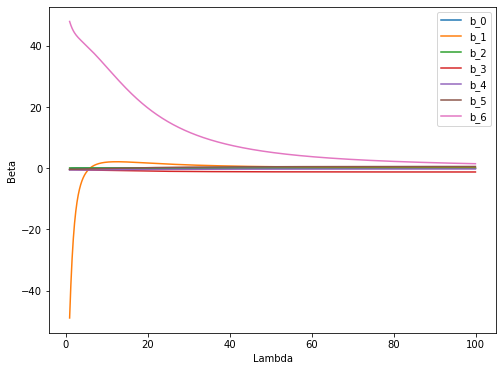

In [23]:
y = longley[['number of people employed']]
x = longley.iloc[:,1:]     

# create intercept 
itcpt = np.repeat(1,16).reshape(-1,1)

x = np.append(x, itcpt, axis = 1)
x = x[:,[6,0,1,2,3,4,5]]


X = x.T.dot(x)
Y = x.T.dot(y)

# lambda from 1 to 100
ly = np.arange(1,100,0.1) 


df = np.arange(1,8).reshape(1,-1) 

# compute and add penalty
for i in ly:
    pty = i * np.eye(7)
    X = X + pty
    c, low = cho_factor(X)
    btas = cho_solve((c,low),Y).reshape(1,-1)
    df = np.vstack((df, btas))

# remove the first r.n given
# combine to df
df = pd.DataFrame(df[1:,:]) 

plt.figure(figsize = (8,6))
plt.plot(ly, df[0], label='b_0')
plt.plot(ly, df[1], label='b_1')
plt.plot(ly, df[2], label='b_2')
plt.plot(ly, df[3], label='b_3')
plt.plot(ly, df[4], label='b_4')
plt.plot(ly, df[5], label='b_5')
plt.plot(ly, df[6], label='b_6')


plt.legend()

plt.xlabel('Lambda')
plt.ylabel('Beta')


plt.show()

# Problem 2

## 2.1

In [24]:
# Read data of csv file. 
A = pd.read_csv("A.txt", sep=',', header=None)
Udf = pd.read_csv("U.txt", header=None)

# Udf.iloc[68]
# Udf.iloc[1]
# Udf.iloc[149]
# Udf.iloc[322]


# delete urls that are not in the right format (1, 68, 149, 322)
Udf.drop([1, 68, 149, 322], inplace=True)
A.drop([1, 68, 149, 322], axis=0, inplace=True)
A.drop([1, 68, 149, 322], axis=1, inplace=True)


In [25]:
At = np.array(A.T)


#### (a) number of pages

In [26]:
# length of url
print(f"The number of pages are {len(Udf)}.")

The number of pages are 496.


#### (b) number of edges (page links)

In [27]:
# count all the 1's in A
print(f"The number of edges (page links) is {np.sum(At)}.")

The number of edges (page links) is 2835.


#### (c) number of dangling nodes

In [28]:
cnt = 0

# count pages that does not linked to the outward link 
for i in range(496):
    if np.sum(At[i,]) == 0:
        cnt +=1

print(f"The number of dangling nodes is : {cnt}.")

The number of dangling nodes is : 208.


#### (d) max in-degree

In [29]:
# max column sum 

Maxindeg = max(A.T.sum(axis=0))

print(f"The max in-degree is : {Maxindeg}.")

The max in-degree is : 54.


#### (e) max out-degree

In [30]:
# max row sum

Maxoutdeg = max(A.T.sum(axis=1))

print(f"The max out-degree is : {Maxoutdeg}.")

The max out-degree is : 51.


#### (f) visualize sparsity pattern of A

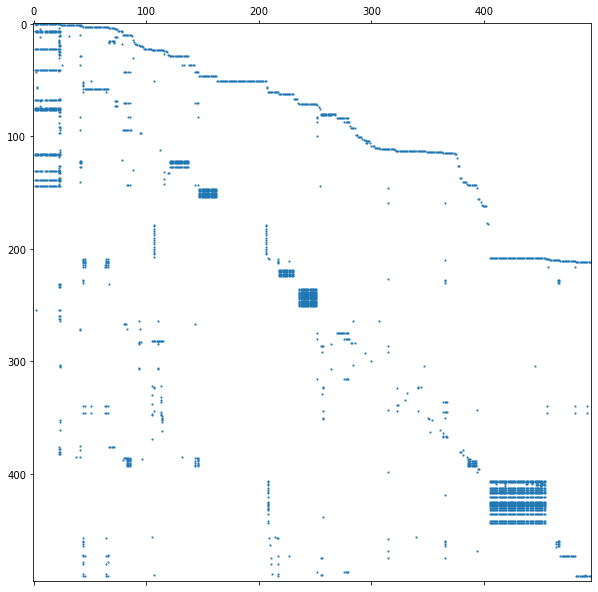

In [31]:
# use pyplot.spy function 

plt.figure(figsize=(10,16))
plt.spy(At,markersize=1)
plt.show();


## 2.2

In [32]:
# data preparing

Att = A.T
Att = np.array(Att)

d = 0.85
ri = Att.sum(axis=1)

H = np.zeros((496,496))

for i in range(len(ri)):
    for j in range(len(ri)):
        if ri[i] > 0:
            H[i][j] = d*(Att[i][j]/ri[i]) + (1-d)/496
        else:
            H[i][j] = 1/ 496





matA = np.eye(496) - H.T
# create a row with 496's 1. 
newrow = np.array(np.repeat(1, len(Att)))

# replace first row of the raw data 

matA[0] = newrow


# create b with 496's 0
b_a = np.array(np.repeat(0, len(Att)))

# reshape to (496,1)
b_a = b_a.reshape(-1, 1)
# b.shape

# repalce 1 from the top

b_a[0] = np.array(1)


b_a.shape
# sparseAt =  sparse.csr_matrix(At)

(496, 1)

#### (a) Dense linear system sover : LU decomposition

In [33]:
# create vector of ones
X0 = np.ones((496,1))

# add 1's in the front column
Anew = np.hstack((X0, matA))
Anewsq = np.dot(np.transpose(Anew), Anew)

start = time.time() 


P_, L_, U_ = sl.lu(Anewsq)


B_a = np.dot(Anew.T, b_a)

Y_a = np.dot(P_.T, B_a)

Ub_a = forward_substitution(L_, Y_a)
betahat_a = back_substitution(U_, Ub_a)



end = time.time() 


print(f"Time cost : {end - start:.5f} sec")
print("The regression coefficient of ucd url by LU decomposition is : ")
# print(np.array_str(betahat_a, precision=10, suppress_small=True))

print(betahat_a)



Time cost : 0.01596 sec
The regression coefficient of ucd url by LU decomposition is : 
[[ 1.10231421e-03]
 [ 5.45814461e-01]
 [ 2.26984207e-02]
 [ 2.51842602e-02]
 [ 2.36019572e-02]
 [ 2.36559223e-02]
 [ 4.28267477e-02]
 [ 2.36559223e-02]
 [ 2.36559223e-02]
 [ 2.17602719e-02]
 [ 2.17602719e-02]
 [ 2.36559223e-02]
 [ 2.36559223e-02]
 [ 2.36559223e-02]
 [ 2.36559223e-02]
 [ 2.36559223e-02]
 [ 2.36559223e-02]
 [ 2.36559223e-02]
 [ 2.36559223e-02]
 [ 2.36559223e-02]
 [ 2.36559223e-02]
 [ 2.36559223e-02]
 [ 2.36559223e-02]
 [ 8.02387106e-02]
 [ 4.95565088e-02]
 [ 3.12946266e-05]
 [ 3.52252138e-06]
 [ 3.12946267e-05]
 [ 3.12946266e-05]
 [ 3.12946266e-05]
 [ 3.12946266e-05]
 [ 3.12946266e-05]
 [ 5.05817811e-03]
 [ 3.12946267e-05]
 [ 3.12946267e-05]
 [ 3.12946267e-05]
 [ 3.12946267e-05]
 [ 3.12946267e-05]
 [-2.94057585e-04]
 [ 3.12946267e-05]
 [ 3.12946267e-05]
 [ 3.12946267e-05]
 [ 1.00921299e-02]
 [-1.70430990e-04]
 [ 9.76992233e-03]
 [-5.12748357e-03]
 [-1.09899114e-03]
 [-6.34883140e-05]


In [34]:
# sorted array index by LU fact.
for i in range(20):
    print(np.where(betahat_a == sorted(betahat_a, reverse=True)[i]))

(array([1], dtype=int64), array([0], dtype=int64))
(array([23], dtype=int64), array([0], dtype=int64))
(array([24], dtype=int64), array([0], dtype=int64))
(array([6], dtype=int64), array([0], dtype=int64))
(array([3], dtype=int64), array([0], dtype=int64))
(array([13], dtype=int64), array([0], dtype=int64))
(array([19], dtype=int64), array([0], dtype=int64))
(array([8], dtype=int64), array([0], dtype=int64))
(array([7], dtype=int64), array([0], dtype=int64))
(array([12], dtype=int64), array([0], dtype=int64))
(array([15], dtype=int64), array([0], dtype=int64))
(array([21], dtype=int64), array([0], dtype=int64))
(array([11], dtype=int64), array([0], dtype=int64))
(array([22], dtype=int64), array([0], dtype=int64))
(array([17], dtype=int64), array([0], dtype=int64))
(array([20], dtype=int64), array([0], dtype=int64))
(array([16], dtype=int64), array([0], dtype=int64))
(array([5], dtype=int64), array([0], dtype=int64))
(array([18], dtype=int64), array([0], dtype=int64))
(array([14], dtype

#### (b) Dense Linear system solver  : QR factorization

In [35]:
start = time.time() 

q, r = sl.qr(Anew)

p_a = np.dot(q.T, np.array(b_a))
xhat_qra = np.dot(np.linalg.pinv(r), p_a)


end = time.time() 

print(f"Time cost : {end - start:.5f} sec")
# print(np.array_str(xhat_qra[1:], precision=10, suppress_small=True))

print(xhat_qra)


Time cost : 0.05186 sec
[[1.02228159e-06]
 [1.38157023e-03]
 [2.44298838e-03]
 [3.10442213e-03]
 [3.42978317e-03]
 [2.54604248e-03]
 [5.44656387e-03]
 [2.54604248e-03]
 [2.54604248e-03]
 [2.14946443e-03]
 [2.14946443e-03]
 [2.54604248e-03]
 [2.54604248e-03]
 [2.54604248e-03]
 [2.54604248e-03]
 [2.54604248e-03]
 [2.54604248e-03]
 [2.54604248e-03]
 [2.54604248e-03]
 [2.54604248e-03]
 [2.54604248e-03]
 [2.54604248e-03]
 [2.54604248e-03]
 [2.55194631e-02]
 [2.24042862e-02]
 [9.78345571e-04]
 [1.10022674e-03]
 [9.78345571e-04]
 [9.78345571e-04]
 [9.78345571e-04]
 [9.78345571e-04]
 [9.78345571e-04]
 [1.51937960e-03]
 [9.78345571e-04]
 [9.78345571e-04]
 [9.78345571e-04]
 [9.78345571e-04]
 [9.78345571e-04]
 [1.29050654e-03]
 [9.78345571e-04]
 [9.78345571e-04]
 [9.78345571e-04]
 [6.95828117e-03]
 [1.22225306e-03]
 [2.19389797e-03]
 [9.36314982e-03]
 [2.09648615e-03]
 [1.03969493e-03]
 [1.03969493e-03]
 [1.03969493e-03]
 [1.03969493e-03]
 [1.03969493e-03]
 [1.30306800e-03]
 [1.03969493e-03]
 [1.

In [36]:
# sorted array index of the beta_hat for qr factorization
for i in range(20):
    print(np.where(xhat_qra == sorted(xhat_qra, reverse=True)[i]))


(array([23], dtype=int64), array([0], dtype=int64))
(array([365], dtype=int64), array([0], dtype=int64))
(array([24], dtype=int64), array([0], dtype=int64))
(array([108], dtype=int64), array([0], dtype=int64))
(array([301], dtype=int64), array([0], dtype=int64))
(array([444], dtype=int64), array([0], dtype=int64))
(array([45], dtype=int64), array([0], dtype=int64))
(array([316], dtype=int64), array([0], dtype=int64))
(array([416], dtype=int64), array([0], dtype=int64))
(array([106], dtype=int64), array([0], dtype=int64))
(array([115], dtype=int64), array([0], dtype=int64))
(array([253], dtype=int64), array([0], dtype=int64))
(array([114], dtype=int64), array([0], dtype=int64))
(array([42], dtype=int64), array([0], dtype=int64))
(array([249], dtype=int64), array([0], dtype=int64))
(array([251], dtype=int64), array([0], dtype=int64))
(array([242], dtype=int64), array([0], dtype=int64))
(array([240], dtype=int64), array([0], dtype=int64))
(array([250], dtype=int64), array([0], dtype=int64

#### (c) A simple iterative linear system solver such as Jacobi or Gauss-Seidel. 

In [37]:

Jmat = np.eye(496) - H.T

Jb = np.ones((496, 1))


start = time.time() 

def jacobi(A,b,N=25,x=None):
    """Solves the equation Ax=b via the Jacobi iterative method."""
    # Create an initial guess if needed                                                                                                                                                            
    if x is None:
        x = np.zeros(len(A[0]))

    # Create a vector of the diagonal elements of A                                                                                                                                                
    # and subtract them from A                                                                                                                                                                     
    D = np.diag(A)
    R = A - np.diagflat(D)

    # Iterate for N times                                                                                                                                                                          
    for i in range(N):
        x = (b - np.dot(R,x)) / D
    return x

xg = np.ones((496,1))

sol = jacobi(Jmat, Jb, N = 30)


print(np.array_str(sol, precision=50, suppress_small=True))

end = time.time() 
print(f"Time cost : {end - start:.5f} sec")


[[11.020314604684366 11.020314604684366 11.020314604684366 ...
  11.270841298379958 11.270841298379958 11.270841298379958]
 [28.967433957528204 28.967433957528204 28.967433957528204 ...
  29.670819509035127 29.670819509035127 29.670819509035127]
 [36.7925162693322   36.7925162693322   36.7925162693322   ...
  37.68964053542626  37.68964053542626  37.68964053542626 ]
 ...
 [12.141743604357055 12.141743604357055 12.141743604357055 ...
  12.419201696149765 12.419201696149765 12.419201696149765]
 [12.141743604357055 12.141743604357055 12.141743604357055 ...
  12.419201696149765 12.419201696149765 12.419201696149765]
 [12.141743604357055 12.141743604357055 12.141743604357055 ...
  12.419201696149765 12.419201696149765 12.419201696149765]]
Time cost : 0.16356 sec


#### (f) List the top 20 ranked URLs you found

In [40]:
temp1 = []

for i in range(20):
    temp1.append(np.where(xhat_qra == sorted(xhat_qra, reverse=True)[i]))

temp2 = []

for i in range(20):
    temp2.append(temp1[i][0][0])

urls = []

for i in temp2:
    urls.append(Udf.iloc[i-1][0])

urls

['http://ucdavis.edu/help/privacy-accessibility.html',
 'http://xmlns.com/foaf/0.1',
 'http://www.universityofcalifornia.edu',
 'http://browsehappy.com',
 'http://creativecommons.org/ns#',
 'http://disabilities.ucsd.edu',
 'http://b',
 'http:\\/\\/schema.org',
 'http://students.ucsd.edu',
 'http://drupal.org)',
 'http://www.ucla.edu',
 'http://schema.org',
 'http://www.berkeley.edu',
 'http://www.ucdavis.edu',
 'http://ucd.alumniplans.com/about-us.html',
 'http://ucd.alumniplans.com/terms-of-use.html',
 'http://ucd.alumniplans.com/personal-insurance/pet-insurance/pet-insurance.html',
 'http://ucd.alumniplans.com/personal-insurance/long-term-care/long-term-care.html',
 'http://ucd.alumniplans.com/privacy-statement.html',
 'http://ucd.alumniplans.com/health-insurance.html']

## 2.3

According to **http://www.worldwidewebsize.com/**, we have at least 2.9 billion indexed webpaes on the internet, and the number of webpages will increase everyday. Thus, to compute the pagerank of the huge amount of webpages, we need an alogrithm that has the smallest time cost. According to what I have researched, Google still use PageRank system to manage those websites. However, since the LU decomposition and QR factorization have larger flop counts for computing a large number of pageranks, it will nearly impossible to use LU decomposition and QR factorization now days. Instead, Google use a simple interative linear system, such asJacobi and Gauss-Seidel, with advanced computational algorithm for calculating pageranks of 2.9 billion webpages.